# Hidden Markov Model

A Hidden Markov Model (HMM) is a statistical model for sequential data where unobservable states (e.g., underlying ancestry) evolve over time according to a Markov chain, and at each time point we observe noisy or indirect measurements that depend on the current hidden state.


# Graphical Summary

![Fig](./graphical_summary/slides/Slide32.png)

# Key Formula

The complete probability of any sequence of hidden states and observations in an HMM is given by:

$$
\mathbb{P}(z_{1:T}, x_{1:T}) = \mathbb{P}(z_1) \prod_{t=2}^{T} \mathbb{P}(z_t | z_{t-1}) \prod_{t=1}^{T} \mathbb{P}(x_t | z_t)
$$

- $z_t$ = hidden state at time $t$ (what's happening behind the scenes)
- $x_t$ = observation at time $t$ (what you can actually see)
- $z_{1:T}$ = sequence of hidden states from time 1 to $T$
- $x_{1:T}$ = sequence of observations from time 1 to $T$
- $T$ = total number of time steps


# Technical Details

## Markov Chain

A Markov chain is a sequence of random variables $z_1, z_2, \ldots, z_T$ where the future state depends only on the current state, not on the history:

$$
\mathbb{P}(z_{t+1} | z_1, z_2, \ldots, z_t) = \mathbb{P}(z_{t+1} | z_t)
$$

This is the **Markov property**. The chain is fully specified by initial distribution $\mathbb{P}(z_1)$ and transition probabilities $\mathbb{P}(z_{t+1} | z_t)$.

An HMM extends this by adding observations: the states $z_t$ are hidden (unobservable), but at each time $t$ we observe $x_t$ that depends only on the current hidden state $z_t$. This is called **output independence**.

## Inference Problem

Given a sequence of observations $x_{1:T}$, we want to infer the hidden states. Specifically, we want to compute the posterior distribution $\mathbb{P}(z_t | x_{1:T})$ for each time $t$. The forward-backward algorithm solves this efficiently using dynamic programming.

## Forward Probability

The forward probability accumulates information from past observations.

**Definition:**

$$
\alpha_t(k) := \mathbb{P}(z_t = k, x_{1:t})
$$

Joint probability of state $k$ at time $t$ and all past observations.

**Forward Recursion:**

$$
\alpha_{t+1}(k) = \mathbb{P}(x_{t+1} | z_{t+1} = k) \sum_{j} \alpha_t(j) \cdot \mathbb{P}(z_{t+1} = k | z_t = j)
$$

## Backward Probability

The backward probability accumulates information from future observations.

**Definition:**

$$
\beta_t(k) := \mathbb{P}(x_{t+1:T} | z_t = k)
$$

Probability of all future observations given state $k$ at time $t$.

**Backward Recursion:**

$$
\beta_t(k) = \sum_{j} \mathbb{P}(z_{t+1} = j | z_t = k) \cdot \mathbb{P}(x_{t+1} | z_{t+1} = j) \cdot \beta_{t+1}(j)
$$

## Posterior Distribution

By the Markov property, conditioning on $z_t$ makes past and future observations independent:

$$
\mathbb{P}(z_t = k, x_{1:T}) = \mathbb{P}(z_t = k, x_{1:t}) \cdot \mathbb{P}(x_{t+1:T} | z_t = k) = \alpha_t(k) \cdot \beta_t(k)
$$

Thus, the posterior distribution is:

$$
\mathbb{P}(z_t = k | x_{1:T}) = \frac{\alpha_t(k) \cdot \beta_t(k)}{\sum_{k'} \alpha_t(k') \cdot \beta_t(k')}
$$

This answers: "Given all observations, what is the probability we were in state $k$ at time $t$?"

# Related Topics

- [minor allele frequency](https://statfungen.github.io/statgen-primer/minor_allele_frequency.html)


# Example

## Example 1: Genotype Imputation

**Problem**: Genotyping arrays are cost-effective but only measure a subset of genetic variants. Given an individual genotyped at sparse markers and a reference panel with dense genotypes, can we infer (impute) the missing genotypes at untyped markers?

**HMM Solution**: Model each individual's haplotype as a mosaic copied from reference haplotypes, with occasional switches due to recombination. The HMM has:

1. **Hidden states**: Which reference haplotype is being copied at each position
2. **Observations**: Observed genotypes at typed markers (emissions)
3. **Transitions**: Recombination events causing switches between reference haplotypes

This Li and Stephens (2003) model captures linkage disequilibrium through the haplotype copying process.

### Step 1: Generate Data

We create a reference panel with complete haplotypes, then simulate a target individual genotyped only at a subset of markers.

In [1]:
rm(list = ls())
set.seed(534)

library(gridExtra)
library(ggplot2)

# Parameters
n_markers <- 100        # Total number of SNP markers
n_ref_haps <- 20        # Number of reference haplotypes
typed_prop <- 0.3       # Proportion of markers that are typed

# Generate reference panel with realistic LD structure
# Use a simple model where allele frequencies vary
allele_freq <- runif(n_markers, 0.2, 0.8)

# Create reference haplotypes with some LD structure
ref_panel <- matrix(0, nrow = n_markers, ncol = n_ref_haps)
for (h in 1:n_ref_haps) {
  # First marker
  ref_panel[1, h] <- rbinom(1, 1, allele_freq[1])
  
  # Subsequent markers have correlation with previous marker
  for (m in 2:n_markers) {
    # Copy previous allele with some probability (creates LD)
    if (runif(1) < 0.7) {
      ref_panel[m, h] <- ref_panel[m-1, h]
    } else {
      ref_panel[m, h] <- rbinom(1, 1, allele_freq[m])
    }
  }
}

# Generate true target haplotype by copying from reference with switches
true_target <- numeric(n_markers)
current_ref <- sample(1:n_ref_haps, 1)  # Start by copying from a random reference
true_copying_path <- numeric(n_markers)
true_copying_path[1] <- current_ref

for (m in 1:n_markers) {
  # Recombination: switch reference haplotype with small probability
  if (m > 1 && runif(1) < 0.05) {
    current_ref <- sample(1:n_ref_haps, 1)
  }
  true_copying_path[m] <- current_ref
  
  # Copy allele from current reference (with small error rate)
  if (runif(1) < 0.98) {
    true_target[m] <- ref_panel[m, current_ref]
  } else {
    true_target[m] <- 1 - ref_panel[m, current_ref]  # Mutation/error
  }
}

# Determine which markers are typed vs. untyped
typed_indices <- sort(sample(1:n_markers, size = round(typed_prop * n_markers)))
untyped_indices <- setdiff(1:n_markers, typed_indices)

# Observed data: only typed markers are known
observed_target <- rep(NA, n_markers)
observed_target[typed_indices] <- true_target[typed_indices]

cat(sprintf("Reference panel: %d haplotypes × %d markers\n", n_ref_haps, n_markers))
cat(sprintf("Target individual: %d typed markers, %d to impute\n", 
            length(typed_indices), length(untyped_indices)))

Reference panel: 20 haplotypes × 100 markers
Target individual: 30 typed markers, 70 to impute


### Step 2: Define HMM Parameters

#### 2.1 Transition Probability $P(Z_m = k | Z_{m-1} = j)$

The probability of switching from copying reference haplotype $j$ to haplotype $k$:

$$
P(Z_m = k | Z_{m-1} = j) = \begin{cases}
1 - \rho & \text{if } k = j \text{ (no switch)}\\
\frac{\rho}{n_{\text{ref hap}}} & \text{if } k \neq j \text{ (switch)}
\end{cases}
$$

where $\rho$ is the recombination/switch rate.

In [2]:
# HMM parameters
rho <- 0.01        # Recombination/switch probability per marker
epsilon <- 0.01    # Mutation/error rate

# Transition probability function
transition_prob_impute <- function(k, j) {
  # Probability of transitioning from state j to state k
  if (k == j) {
    return(1 - rho)  # Stay in same state
  } else {
    return(rho / n_ref_haps)  # Switch to different state (uniform)
  }
}

#### 2.2 Emission Probability $P(X_m = x | Z_m = k)$

The probability of observing allele $x$ given we're copying from reference haplotype $k$:

$$
P(X_m = x | Z_m = k) = \begin{cases}
1 - \epsilon & \text{if } x = \text{ref}_k[m] \text{ (match)}\\
\epsilon & \text{if } x \neq \text{ref}_k[m] \text{ (mismatch)}
\end{cases}
$$

where $\epsilon$ is the mutation/error rate. For untyped markers, the emission is uniform (uninformative).

In [3]:
# Emission probability function
emission_prob_impute <- function(observed, ref_allele, m) {
  # observed: observed allele at marker m (NA if untyped)
  # ref_allele: allele in reference haplotype at marker m
  
  if (is.na(observed)) {
    # Untyped marker: emission probability is 1 (uninformative)
    return(1)
  } else if (observed == ref_allele) {
    # Match: high probability
    return(1 - epsilon)
  } else {
    # Mismatch: low probability (mutation/error)
    return(epsilon)
  }
}

### Step 3: Run Forward-Backward Algorithm

We use forward-backward to compute posterior probabilities of copying from each reference haplotype at each position.

#### 3.1 Forward Probability $\alpha_m(k)$

$$
\alpha_m(k) = P(X_{1:m}, Z_m = k)
$$

This is the joint probability of typed observations up to marker $m$ AND copying from reference haplotype $k$ at marker $m$.

In [4]:
# Initialize forward probabilities
forward_impute <- matrix(0, nrow = n_markers, ncol = n_ref_haps)

# Base case: marker 1 (uniform prior over reference haplotypes)
for (k in 1:n_ref_haps) {
  forward_impute[1, k] <- (1 / n_ref_haps) * 
                          emission_prob_impute(observed_target[1], ref_panel[1, k], 1)
}
# Normalize
forward_impute[1, ] <- forward_impute[1, ] / sum(forward_impute[1, ])

# Forward recursion
for (m in 2:n_markers) {
  for (k in 1:n_ref_haps) {
    # Sum over all previous states
    sum_val <- 0
    for (j in 1:n_ref_haps) {
      sum_val <- sum_val + forward_impute[m-1, j] * transition_prob_impute(k, j)
    }
    forward_impute[m, k] <- emission_prob_impute(observed_target[m], ref_panel[m, k], m) * sum_val
  }
  # Normalize to prevent underflow
  forward_impute[m, ] <- forward_impute[m, ] / sum(forward_impute[m, ])
}

#### 3.2 Backward Probability $\beta_m(k)$

$$
\beta_m(k) = P(X_{m+1:M} | Z_m = k)
$$

This is the probability of future typed observations given we're copying from reference haplotype $k$ at marker $m$.

In [5]:
# Initialize backward probabilities
backward_impute <- matrix(1, nrow = n_markers, ncol = n_ref_haps)

# Backward recursion
for (m in (n_markers-1):1) {
  for (k in 1:n_ref_haps) {
    sum_val <- 0
    for (j in 1:n_ref_haps) {
      sum_val <- sum_val + 
        transition_prob_impute(j, k) *
        emission_prob_impute(observed_target[m+1], ref_panel[m+1, j], m+1) *
        backward_impute[m+1, j]
    }
    backward_impute[m, k] <- sum_val
  }
  # Normalize to prevent underflow
  backward_impute[m, ] <- backward_impute[m, ] / sum(backward_impute[m, ])
}

#### 3.3 Compute Posterior and Impute Genotypes

For each untyped marker, compute $P(Z_m = k | X_{\text{typed}}) \propto \alpha_m(k) \cdot \beta_m(k)$, then impute the genotype as the expected value over reference haplotypes.

In [6]:
# Compute posterior probabilities
posterior_copying <- matrix(0, nrow = n_markers, ncol = n_ref_haps)
for (m in 1:n_markers) {
  posterior_copying[m, ] <- forward_impute[m, ] * backward_impute[m, ]
  posterior_copying[m, ] <- posterior_copying[m, ] / sum(posterior_copying[m, ])
}

# Impute genotypes at untyped markers
imputed_genotypes <- numeric(n_markers)
imputed_genotypes[typed_indices] <- observed_target[typed_indices]

for (m in untyped_indices) {
  # Expected genotype = sum over reference haplotypes weighted by posterior
  imputed_genotypes[m] <- sum(posterior_copying[m, ] * ref_panel[m, ])
  # Round to nearest integer (0 or 1)
  imputed_genotypes[m] <- round(imputed_genotypes[m])
}

# Calculate imputation accuracy
imputation_accuracy <- sum(imputed_genotypes[untyped_indices] == true_target[untyped_indices]) / 
                       length(untyped_indices)

cat("\n=================================================================\n")
cat("GENOTYPE IMPUTATION RESULTS\n")
cat("=================================================================\n")
cat(sprintf("Imputation accuracy: %.1f%% (%d/%d markers correct)\n", 
            imputation_accuracy * 100,
            sum(imputed_genotypes[untyped_indices] == true_target[untyped_indices]),
            length(untyped_indices)))


GENOTYPE IMPUTATION RESULTS
Imputation accuracy: 90.0% (63/70 markers correct)


### Step 4: Results

We visualize the imputation process and accuracy.

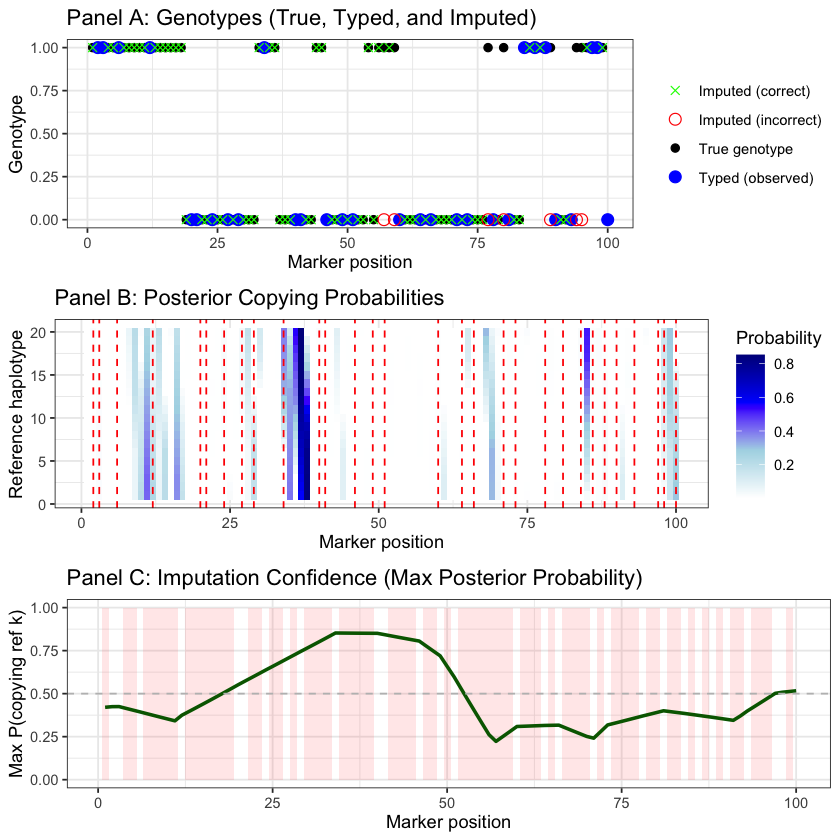

In [7]:
# Separate correct and incorrect imputations
correct_idx <- untyped_indices[imputed_genotypes[untyped_indices] == true_target[untyped_indices]]
incorrect_idx <- untyped_indices[imputed_genotypes[untyped_indices] != true_target[untyped_indices]]

# Panel 1: Genotypes
df1 <- data.frame(
  position = rep(1:n_markers, 4),
  genotype = c(true_target, 
               ifelse(1:n_markers %in% typed_indices, observed_target, NA),
               ifelse(1:n_markers %in% correct_idx, imputed_genotypes, NA),
               ifelse(1:n_markers %in% incorrect_idx, imputed_genotypes, NA)),
  type = rep(c("True genotype", "Typed (observed)", "Imputed (correct)", "Imputed (incorrect)"), 
             each = n_markers)
)

# Remove rows with NA genotypes
df1 <- df1[!is.na(df1$genotype), ]

p1 <- ggplot(df1, aes(x = position, y = genotype, color = type, shape = type, size = type)) +
  geom_point() +
  scale_color_manual(values = c("True genotype" = "black", "Typed (observed)" = "blue", 
                                  "Imputed (correct)" = "green", "Imputed (incorrect)" = "red")) +
  scale_shape_manual(values = c("True genotype" = 19, "Typed (observed)" = 19, 
                                 "Imputed (correct)" = 4, "Imputed (incorrect)" = 1)) +
  scale_size_manual(values = c("True genotype" = 2, "Typed (observed)" = 3, 
                                "Imputed (correct)" = 2, "Imputed (incorrect)" = 3)) +
  labs(x = "Marker position", y = "Genotype", title = "Panel A: Genotypes (True, Typed, and Imputed)") +
  theme_bw() +
  theme(legend.title = element_blank())

# Panel 2: Heatmap
df2 <- data.frame(
  marker = rep(1:n_markers, each = n_ref_haps),
  haplotype = rep(1:n_ref_haps, n_markers),
  probability = c(posterior_copying)
)

p2 <- ggplot(df2, aes(x = marker, y = haplotype, fill = probability)) +
  geom_tile() +
  scale_fill_gradientn(colors = c("white", "lightblue", "blue", "darkblue"),
                       name = "Probability") +
  geom_vline(xintercept = typed_indices, color = "red", linetype = "dashed", linewidth = 0.5) +
  labs(x = "Marker position", y = "Reference haplotype", 
       title = "Panel B: Posterior Copying Probabilities") +
  theme_bw()

# Panel 3: Confidence
max_posterior <- apply(posterior_copying, 1, max)
df3 <- data.frame(
  position = 1:n_markers,
  confidence = max_posterior,
  is_untyped = 1:n_markers %in% untyped_indices
)

p3 <- ggplot(df3, aes(x = position)) +
  geom_rect(data = df3[df3$is_untyped, ], 
            aes(xmin = position - 0.5, xmax = position + 0.5, ymin = 0, ymax = 1),
            fill = "red", alpha = 0.1) +
  geom_line(aes(y = confidence), color = "darkgreen", linewidth = 1) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "gray") +
  labs(x = "Marker position", y = "Max P(copying ref k)", 
       title = "Panel C: Imputation Confidence (Max Posterior Probability)") +
  ylim(0, 1) +
  theme_bw()

# Combine panels
grid.arrange(p1, p2, p3, ncol = 1)

The results show successful genotype imputation using the HMM:
- Panel A displays the comparison between true genotypes (black), typed markers (blue), and imputed genotypes (green crosses for correct, red circles for incorrect). 
- Panel B is a heatmap showing $P(Z_m = k | X_{\text{typed}})$ - the posterior probability of copying from each reference haplotype $k$ (y-axis, 1-20) at each marker position $m$ (x-axis, 1-100). Darker blue indicates higher probability. The horizontal bands reveal that the target primarily copies from a few reference haplotypes, switching between them due to recombination (as expected from the mosaic structure). The vertical red lines mark typed markers that anchor the inference. 
- Panel C shows imputation confidence (maximum posterior probability across all reference haplotypes), with higher confidence at typed markers and nearby positions due to linkage disequilibrium. The shaded regions highlight untyped markers where imputation was performed. The HMM leverages LD structure in the reference panel to accurately impute most untyped genotypes, with confidence decreasing in regions distant from typed markers.

## Example 2: Local Ancestry Inference with ELAI

**Problem**: When populations mix through migration and intermarriage, their descendants carry chromosomal segments from different ancestral populations. Given an admixed individual's genome and reference panels from ancestral populations, can we infer which population each genomic segment originated from?

**ELAI's Solution**: A two-layer Hidden Markov Model that captures genetic variation at two scales:

1. **Upper Layer**: Which ancestral **population** (e.g., European vs. African)
   - Captures long-range admixture LD (1-10 cM)

2. **Lower Layer**: Which specific ancestral **haplotype** within that population
   - Captures fine-scale within-population LD (0.1-1 cM)

This hierarchical structure models both the ancestry switches created by admixture and the haplotype copying process within populations.

### Step 1: Generate Data

We first create reference populations with distinct allele frequencies, then simulate an admixed individual as a mosaic of segments from these populations (mimicking recombination history during admixture).

In [8]:
rm(list = ls())
set.seed(720)
# Parameters
n_markers <- 50          # Number of SNP markers
n_ref_haps_per_pop <- 10 # Reference haplotypes per population

# Population 1 (e.g., European): lower allele frequencies
# Make populations VERY distinct for clear inference
pop1_freq <- runif(n_markers, 0.05, 0.25)

# Population 2 (e.g., African): higher allele frequencies
pop2_freq <- runif(n_markers, 0.75, 0.95)

# Generate reference haplotypes
ref_pop1 <- matrix(
  rbinom(n_markers * n_ref_haps_per_pop, 1, prob = rep(pop1_freq, n_ref_haps_per_pop)),
  nrow = n_markers,
  ncol = n_ref_haps_per_pop
)

ref_pop2 <- matrix(
  rbinom(n_markers * n_ref_haps_per_pop, 1, prob = rep(pop2_freq, n_ref_haps_per_pop)),
  nrow = n_markers,
  ncol = n_ref_haps_per_pop
)

In [9]:
# Simulate true ancestry with random ancestry blocks
# Start with all markers from population 1
true_ancestry <- rep(1, n_markers)

# Define ancestry switch points (simulating recombination events)
switch_rate <- 0.05  # Probability of ancestry switch at each marker
for (m in 2:n_markers) {
  if (runif(1) < switch_rate) {
    # Switch ancestry
    true_ancestry[m:n_markers] <- 3 - true_ancestry[m-1]  # Switch between 1 and 2
  } else {
    # Keep same ancestry as previous marker
    true_ancestry[m] <- true_ancestry[m-1]
  }
}

# Generate observed haplotype by copying from appropriate population
observed_haplotype <- numeric(n_markers)
for (m in 1:n_markers) {
  # Select reference panel based on true ancestry
  ref_panel <- if (true_ancestry[m] == 1) ref_pop1 else ref_pop2
  
  # Copy allele from a random haplotype in the reference panel
  donor_hap <- sample(1:n_ref_haps_per_pop, 1)
  observed_haplotype[m] <- ref_panel[m, donor_hap]
}

### Step 2: Define Model Parameters and Probability Functions

We now set up ELAI's two-layer HMM by defining the model parameters and the emission/transition probabilities.

In [10]:
# UPPER LAYER: Ancestral populations
S <- 2  # Number of populations
upper_clusters <- 1:S

# LOWER LAYER: Ancestral haplotypes within each population
K <- 4  # Total number of lower-layer clusters (2 per population for simplicity)

# Admixture proportion - based on true ancestry created earlier
true_admix <- c(mean(true_ancestry == 1), mean(true_ancestry == 2))
admix_proportion <- true_admix  # Use true proportions for better inference

#### 2.1 Allele Frequencies $\theta_{mk}$

Each lower-layer cluster represents an ancestral haplotype with its own allele frequency at each marker. These frequencies determine the emission probabilities.

In [11]:
# Cluster allele frequencies (theta in ELAI notation)
# Clusters 1-2: similar to population 1
# Clusters 3-4: similar to population 2
# Use very small noise to keep clusters very close to population frequencies
theta <- matrix(0, nrow = n_markers, ncol = K)
theta[, 1] <- pop1_freq + rnorm(n_markers, 0, 0.01)
theta[, 2] <- pop1_freq + rnorm(n_markers, 0, 0.01)
theta[, 3] <- pop2_freq + rnorm(n_markers, 0, 0.01)
theta[, 4] <- pop2_freq + rnorm(n_markers, 0, 0.01)
theta <- pmax(pmin(theta, 0.95), 0.05)  # Keep in valid range [0.05, 0.95]

# Add column and row names
colnames(theta) <- paste0("Cluster", 1:K)
rownames(theta) <- paste0("Marker", 1:n_markers)

# Show first 5 markers
cat("Allele frequencies (first 5 markers):\n")

round(theta[1:5, ], 3)

Allele frequencies (first 5 markers):


,Cluster1,Cluster2,Cluster3,Cluster4
Marker1,0.096,0.088,0.912,0.941
Marker2,0.223,0.229,0.856,0.859
Marker3,0.064,0.069,0.797,0.783
Marker4,0.104,0.112,0.927,0.943
Marker5,0.168,0.182,0.821,0.811


**Interpretation**: $\theta_{mk}$ = probability that ancestral haplotype $k$ carries allele "1" at marker $m$.

#### 2.2 Beta $\beta_{sk}$: Layer Connection Matrix

$\beta_{sk}$ connects the two layers - the probability that lower-layer cluster $k$ belongs to upper-layer population $s$.

In [12]:
# Beta: probability that lower cluster k belongs to upper cluster s
beta <- matrix(0, nrow = S, ncol = K)
beta[1, 1:2] <- c(0.6, 0.4)  # Pop 1 uses clusters 1 and 2
beta[2, 3:4] <- c(0.5, 0.5)  # Pop 2 uses clusters 3 and 4
rownames(beta) <- paste0("Pop", 1:S)
colnames(beta) <- paste0("Cluster", 1:K)

cat("Beta matrix (connection between layers):\n")
beta

Beta matrix (connection between layers):


,Cluster1,Cluster2,Cluster3,Cluster4
Pop1,0.6,0.4,0.0,0.0
Pop2,0.0,0.0,0.5,0.5


**Interpretation**: For example, $\beta_{1,1} = 0.6$ means "if in population 1, 60% chance of copying from lower cluster 1."

#### 2.3 Transition Parameters $j$ and $\rho$

These parameters control state changes along the chromosome.

In [13]:
rho <- 0.03     # Lower-layer switch probability (within-population recombination)
                # Small value allows stable ancestry blocks
j_prob <- 0.01  # Upper-layer switch probability (ancestry switch)
                # Very small to match the rare ancestry switches in the data

cat(sprintf("Transition probabilities:\n"))
cat(sprintf(" rho = %.2f  [Lower layer switch - recombination within population]\n", rho))
cat(sprintf(" j   = %.2f  [Upper layer switch - ancestry change]\n", j_prob))

Transition probabilities:
 rho = 0.03  [Lower layer switch - recombination within population]
 j   = 0.01  [Upper layer switch - ancestry change]


**Interpretation**: 
- $j$ (upper layer): Ancestry switch rate between populations 
- $\rho$ (lower layer): Haplotype switch rate within a population

#### 2.4 Emission Probability $P(h_m | Y_m = k)$

Given ancestral haplotype $k$, the observed allele follows a Bernoulli distribution:

$$
p(h_m | Y_m = k, \theta) = \begin{cases} 
\theta_{mk} & \text{if } h_m = 1 \\
1 - \theta_{mk} & \text{if } h_m = 0
\end{cases}
$$

In [14]:
# Emission probability function
emission_prob <- function(h_m, k, m) {
  # h_m: observed allele (0 or 1)
  # k: lower-layer cluster
  # m: marker position
  if (h_m == 1) {
    return(theta[m, k])
  } else {
    return(1 - theta[m, k])
  }
}

# Example: probability of observing allele 1 at marker 1 from cluster 1
cat(sprintf("Example: P(observe '1' at marker 1 | cluster 1) = %.3f\n", 
    emission_prob(1, 1, 1)))
cat(sprintf("Example: P(observe '0' at marker 1 | cluster 1) = %.3f\n", 
    emission_prob(0, 1, 1)))

Example: P(observe '1' at marker 1 | cluster 1) = 0.096
Example: P(observe '0' at marker 1 | cluster 1) = 0.904


**Interpretation**: Once you know which ancestral haplotype you're copying from, the allele probability is straightforward.

#### 2.5 Transition Probability $P(X_m=s, Y_m=k | X_{m-1}=s', Y_{m-1}=k')$

ELAI's key innovation - the transition has **three terms** for different biological scenarios:

$$
P(X_m=s, Y_m=k | X_{m-1}=s', Y_{m-1}=k') = 
$$

$$
\underbrace{j \cdot a_s \cdot \beta_{sk}}_{\text{Ancestry switch}} + 
\underbrace{(1-j) \cdot \rho \cdot \beta_{sk} \cdot I(s=s')}_{\text{Haplotype switch}} + 
\underbrace{(1-j) \cdot (1-\rho) \cdot I(s=s') \cdot I(k=k')}_{\text{No switch}}
$$

- **Term 1**: Change populations (both layers change)
- **Term 2**: Stay in population, switch haplotypes (only lower layer changes)
- **Term 3**: Continue copying same haplotype (no change)

In [15]:
# Transition probability function
transition_prob <- function(s, k, s_prev, k_prev, m) {
  # s, k: current state (upper cluster, lower cluster)
  # s_prev, k_prev: previous state
  # m: marker position
  
  # Term 1: Upper layer switches (both layers must change)
  term1 <- j_prob * admix_proportion[s] * beta[s, k]
  
  # Term 2: Only lower layer switches (upper stays same)
  term2 <- (1 - j_prob) * rho * beta[s, k] * (s == s_prev)
  
  # Term 3: No switches (stay in same state)
  term3 <- (1 - j_prob) * (1 - rho) * (s == s_prev) * (k == k_prev)
  
  return(term1 + term2 + term3)
}

# Example: staying in state (1,1)
cat(sprintf("Example: P(stay in state (s=1, k=1)) = %.4f\n", 
    transition_prob(1, 1, 1, 1, 2)))

# Example: switching populations
cat(sprintf("Example: P(switch from (s=1, k=1) to (s=2, k=3)) = %.4f\n", 
    transition_prob(2, 3, 1, 1, 2)))

Example: P(stay in state (s=1, k=1)) = 0.9816
Example: P(switch from (s=1, k=1) to (s=2, k=3)) = 0.0021


### Step 3: Run Forward-Backward Algorithm

We apply the forward-backward algorithm to compute posterior probabilities.

#### 3.1 Forward Probability $\alpha_m(s,k)$

$$
\alpha_m(s,k) = P(h_{1:m}, X_m=s, Y_m=k)
$$

This is the joint probability of observing markers 1 to $m$ AND being in state $(s,k)$ at marker $m$.

In [16]:
# Initialize forward probabilities
forward <- array(0, dim = c(n_markers, S, K))

# Base case: marker 1
for (s in 1:S) {
  for (k in 1:K) {
    forward[1, s, k] <- admix_proportion[s] * beta[s, k] * 
                        emission_prob(observed_haplotype[1], k, 1)
  }
}

cat("Forward algorithm - initialization at marker 1:\n")
cat("State (s=1, k=1):", forward[1, 1, 1], "\n")
cat("State (s=2, k=3):", forward[1, 2, 3], "\n")

# Forward recursion
for (m in 2:n_markers) {
  for (s in 1:S) {
    for (k in 1:K) {
      # Sum over all previous states
      sum_val <- 0
      for (s_prev in 1:S) {
        for (k_prev in 1:K) {
          sum_val <- sum_val + 
            forward[m-1, s_prev, k_prev] * 
            transition_prob(s, k, s_prev, k_prev, m)
        }
      }
      forward[m, s, k] <- emission_prob(observed_haplotype[m], k, m) * sum_val
    }
  }
  # Normalize to prevent underflow
  forward[m, , ] <- forward[m, , ] / sum(forward[m, , ])
}

cat("\nForward algorithm completed for all", n_markers, "markers\n")

Forward algorithm - initialization at marker 1:
State (s=1, k=1): 0.3147502 
State (s=2, k=3): 0.01840828 

Forward algorithm completed for all 50 markers


**Key insight**: Forward probabilities accumulate information from the past.

#### 3.2 Backward Probability $\beta_m(s,k)$

$$
\beta_m(s,k) = P(h_{m+1:M} | X_m=s, Y_m=k)
$$

This is the probability of observing future markers $(m+1)$ to $M$ GIVEN state $(s,k)$ at marker $m$.

In [17]:
# Initialize backward probabilities
backward <- array(1, dim = c(n_markers, S, K))

# Backward recursion
for (m in (n_markers-1):1) {
  for (s in 1:S) {
    for (k in 1:K) {
      sum_val <- 0
      for (s_next in 1:S) {
        for (k_next in 1:K) {
          sum_val <- sum_val + 
            transition_prob(s_next, k_next, s, k, m+1) *
            emission_prob(observed_haplotype[m+1], k_next, m+1) *
            backward[m+1, s_next, k_next]
        }
      }
      backward[m, s, k] <- sum_val
    }
  }
  # Normalize to prevent underflow
  backward[m, , ] <- backward[m, , ] / sum(backward[m, , ])
}

cat("Backward algorithm completed for all", n_markers, "markers\n")

Backward algorithm completed for all 50 markers


**Key insight**: Backward probabilities accumulate information from the future.

#### 3.3 Posterior Probability $P(X_m=s | h_{1:M})$

Combining forward and backward: 

$$
P(X_m=s | h_{1:M}) \propto \sum_k \alpha_m(s,k) \cdot \beta_m(s,k)
$$

In [18]:
# Compute posterior probability: P(X_m = s | observed data)
posterior_ancestry <- matrix(0, nrow = n_markers, ncol = S)

for (m in 1:n_markers) {
  for (s in 1:S) {
    # Sum over all lower clusters k
    for (k in 1:K) {
      posterior_ancestry[m, s] <- posterior_ancestry[m, s] + 
                                  forward[m, s, k] * backward[m, s, k]
    }
  }
  # Normalize
  posterior_ancestry[m, ] <- posterior_ancestry[m, ] / sum(posterior_ancestry[m, ])
}

# Most likely ancestry at each marker
inferred_ancestry <- apply(posterior_ancestry, 1, which.max)

# Calculate accuracy
accuracy <- sum(inferred_ancestry == true_ancestry) / n_markers

cat("\n=================================================================\n")
cat("LOCAL ANCESTRY INFERENCE RESULTS\n")
cat("=================================================================\n")
cat(sprintf("\nAccuracy: %.1f%% of markers correctly assigned\n", accuracy * 100))

# Estimated vs true admixture proportions
estimated_admix <- colMeans(posterior_ancestry)
cat("\nGlobal Admixture Proportions:\n")
cat(sprintf("  Population 1: True = %.2f, Estimated = %.2f\n", 
            mean(true_ancestry == 1), estimated_admix[1]))
cat(sprintf("  Population 2: True = %.2f, Estimated = %.2f\n", 
            mean(true_ancestry == 2), estimated_admix[2]))


LOCAL ANCESTRY INFERENCE RESULTS

Accuracy: 96.0% of markers correctly assigned

Global Admixture Proportions:
  Population 1: True = 0.58, Estimated = 0.62
  Population 2: True = 0.42, Estimated = 0.38


### Step 4: Results

The posterior probability $P(X_m=s | \text{all data})$ quantifies confidence in each ancestry assignment.

The four panels show the complete inference pipeline:
- **Panel A**: Observed haplotype (raw data)
- **Panel B**: Population allele frequencies (model input)
- **Panel C**: True local ancestry (ground truth)
- **Panel D**: Inferred ancestry with uncertainty (HMM output)

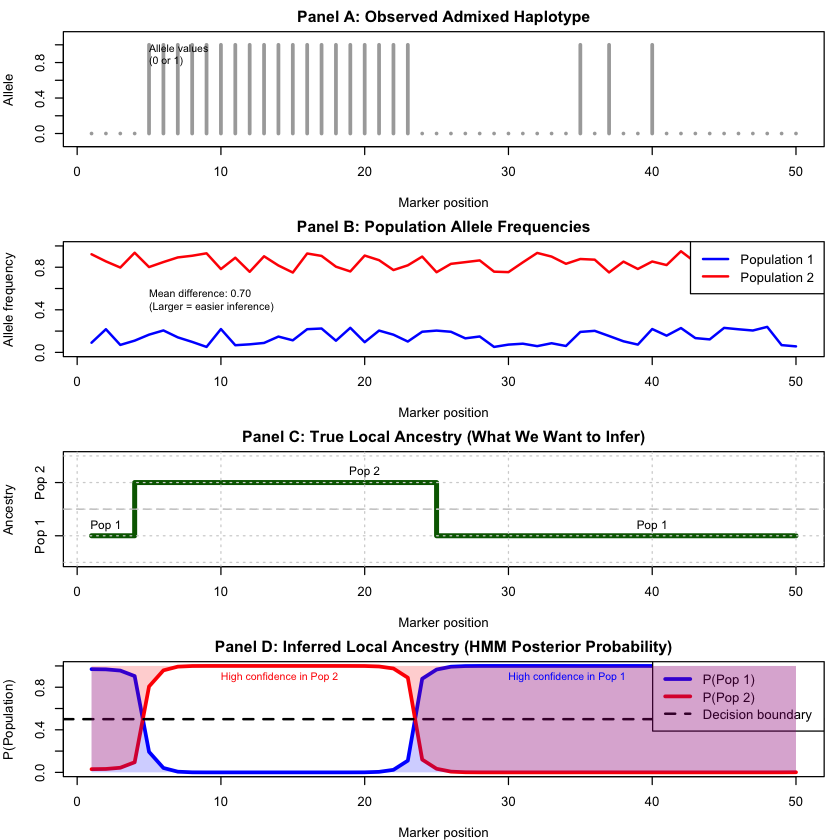

In [30]:
par(mfrow = c(4, 1), mar = c(4, 4, 2, 1))

# Panel 1: Observed haplotype
plot(1:n_markers, observed_haplotype, type = "h", lwd = 3, col = "darkgray",
     xlab = "Marker position", ylab = "Allele", 
     main = "Panel A: Observed Admixed Haplotype",
     ylim = c(-0.1, 1.1))
text(5, 0.9, "Allele values\n(0 or 1)", adj = 0, cex = 0.8)

# Panel 2: Allele frequency comparison
plot(1:n_markers, pop1_freq, type = "l", lwd = 2, col = "blue", 
     ylim = c(0, 1), xlab = "Marker position", 
     ylab = "Allele frequency",
     main = "Panel B: Population Allele Frequencies")
lines(1:n_markers, pop2_freq, lwd = 2, col = "red")
legend("topright", legend = c("Population 1", "Population 2"), 
       col = c("blue", "red"), lwd = 2)
text(5, 0.5, sprintf("Mean difference: %.2f\n(Larger = easier inference)", 
                     mean(pop2_freq - pop1_freq)), adj = 0, cex = 0.8)

# Panel 3: True ancestry
plot(1:n_markers, true_ancestry, type = "s", lwd = 4, col = "darkgreen",
     xlab = "Marker position", ylab = "Ancestry", 
     main = "Panel C: True Local Ancestry (What We Want to Infer)",
     ylim = c(0.5, 2.5), yaxt = "n")
axis(2, at = 1:2, labels = c("Pop 1", "Pop 2"))
abline(h = 1.5, lty = 2, col = "gray")
grid()
# Add ancestry block labels
text(2, 1.2, "Pop 1", cex = 0.9)
text(20, 2.2, "Pop 2", cex = 0.9)
text(40, 1.2, "Pop 1", cex = 0.9)

# Panel 4: Inferred ancestry with uncertainty
plot(1:n_markers, posterior_ancestry[, 1], type = "l", lwd = 3, col = "blue",
     xlab = "Marker position", ylab = "P(Population)", 
     main = "Panel D: Inferred Local Ancestry (HMM Posterior Probability)",
     ylim = c(0, 1))
lines(1:n_markers, posterior_ancestry[, 2], lwd = 3, col = "red")
abline(h = 0.5, lty = 2, col = "black", lwd = 2)
legend("topright", 
       legend = c("P(Pop 1)", "P(Pop 2)", "Decision boundary"), 
       col = c("blue", "red", "black"), lwd = c(3, 3, 2), lty = c(1, 1, 2))
# Shade regions by most likely ancestry
polygon(c(1:n_markers, n_markers:1), 
        c(posterior_ancestry[, 1], rep(0, n_markers)),
        col = rgb(0, 0, 1, 0.2), border = NA)
polygon(c(1:n_markers, n_markers:1), 
        c(posterior_ancestry[, 2], rep(1, n_markers)),
        col = rgb(1, 0, 0, 0.2), border = NA)
text(30, 0.9, "High confidence in Pop 1", adj = 0, cex = 0.8, col = "blue")
text(10, 0.9, "High confidence in Pop 2", adj = 0, cex = 0.8, col = "red")

The results show successful local ancestry inference. Panel D's posterior probabilities closely track the true ancestry (Panel C), with high confidence in most regions and uncertainty only near ancestry switches. The model accurately estimates global admixture proportions and achieves high per-marker accuracy by leveraging population allele frequency differences (Panel B) and LD structure.

**Note on implementation**: This example uses known parameters for clarity. The actual ELAI method uses an Expectation-Maximization (EM) algorithm to iteratively estimate parameters from data, alternating between computing posteriors (E-step) and updating parameters (M-step).

# Extended Reading

- Both ELAI and RFMix are local ancestry inference tools used in population genetics to identify ancestry along chromosomes in admixed individuals. In contrast to ELAI's two-layer hidden Markov model, RFMix employs a discriminative approach using random forests combined with a conditional random field framework for ancestry inference.
  - Guan, Yongtao. ["Detecting structure of haplotypes and local ancestry."](https://academic.oup.com/genetics/article/196/3/625/5935669?login=true) Genetics 196.3 (2014): 625-642.
  - Maples, Brian K., et al. ["RFMix: a discriminative modeling approach for rapid and robust local-ancestry inference."](https://www.sciencedirect.com/science/article/pii/S0002929713002899?via%3Dihub) The American Journal of Human Genetics 93.2 (2013): 278-288.
- [A technical minimum example of HMM](http://stephens999.github.io/fiveMinuteStats/hmm.html) from Matthew Stephens
- More about genotype imputation: Section 3.2: Genotype imputation from [Handbook of Statistical Genomics, 4th edition, by David J. Balding](https://www.wiley.com/en-us/Handbook+of+Statistical+Genomics%2C+4th+Edition-p-9781119429142), especially Figure 3.4.